In [9]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os

In [10]:
################################'Generate regressor X from an AR(1)'##############################
################################ Xt = α + βXt-1 + εt

T=1000;  # sample size
df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_x', 'epsilon_y' ])
alpha = 1;    # intercept parameter
beta = 0.9;   # autoregressive parameter
sigma = 3;  # standard error of innovations
x1 = alpha/(1-beta) # define initial value for time series x
mu=1.7

epsilon = sigma*np.random.randn(T) + mu; # generate a vector of T random normal
df.iloc[0,:] = [x1] # initialize x

for i in range(0, T-1):
    df.iloc[i+1,0] = alpha + beta * df.iloc[i,0] + epsilon[i+1] # generate X(t) recursively
    # Xt = α + βXt-1 + εt


In [11]:
################################ Generate Y ##############################
################################ # Yt = α + βYt-1 + γXt + εt + θεt-1

T_2=1000
alpha_y = 6
beta_y = 0.3
gamma = 0.9
theta = 0.9
sigma = 8
epsilon_y = sigma*np.random.randn(T_2,1)
df['epsilon_y'] = epsilon_y
y1 = 0
df['y'] = 0

for j in range(0, T-1):
    df.iloc[j+1,1] = alpha_y + beta_y * df.iloc[j,1] + gamma * df.iloc[j+1,0] + epsilon_y[j] + theta * epsilon_y[j-1]
    # Yt = α + βYt-1 + γXt + εt + θεt-1

print(df)


             x          y epsilon_x  epsilon_y
0         10.0   0.000000      10.0 -12.834366
1    13.019059   1.515727       NaN  -3.785069
2    16.931079   6.356691       NaN  -0.808321
3    14.649278  16.876475       NaN   7.053201
4    16.817524  32.524426       NaN  -0.365548
..         ...        ...       ...        ...
995   19.83612  38.057948       NaN  -3.270945
996   23.37014  39.622386       NaN  -4.709397
997  24.922248  32.663492       NaN  11.740199
998  22.996071  43.997253       NaN  11.660700
999  25.177181  64.085518       NaN  -3.741178

[1000 rows x 4 columns]


In [12]:
import statsmodels.formula.api as smf

# Fit quantile regression at the 0.5 quantile
y = df['y'].values.astype(float)
x = df['x'].values.astype(float)
epsilon_y = df['epsilon_y'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon_y, 1)
epsilon_lag[0] = 0

quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.1)
quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.5)
quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.9)

#quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.1)
#quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x ).fit(q=0.5)
#quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x + epsilon_y + theta * epsilon_lag).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary())


                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.2478
Model:                       QuantReg   Bandwidth:                       4.479
Method:                 Least Squares   Sparsity:                        56.89
Date:                Fri, 21 Apr 2023   No. Observations:                 1000
Time:                        12:03:56   Df Residuals:                      999
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6814      0.012     58.837      0.000       0.659       0.704
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3182
Model:                       QuantReg   Bandwidth:  

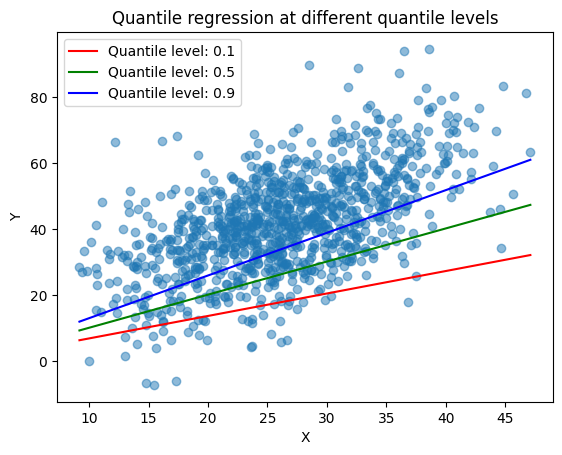

In [13]:
################################ Quantile regression plot ##############################
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
# Create a scatter plot of the data
plt.scatter(x, y, alpha=0.5)

# Plot the quantile regression lines at different quantile levels
x_sort = np.sort(x)
y_pred_1 = quant_reg_1.predict(x_sort)
y_pred_5 = quant_reg_5.predict(x_sort)
y_pred_9 = quant_reg_9.predict(x_sort)

plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

# Add a legend and labels to the plot
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quantile regression at different quantile levels')
plt.show()



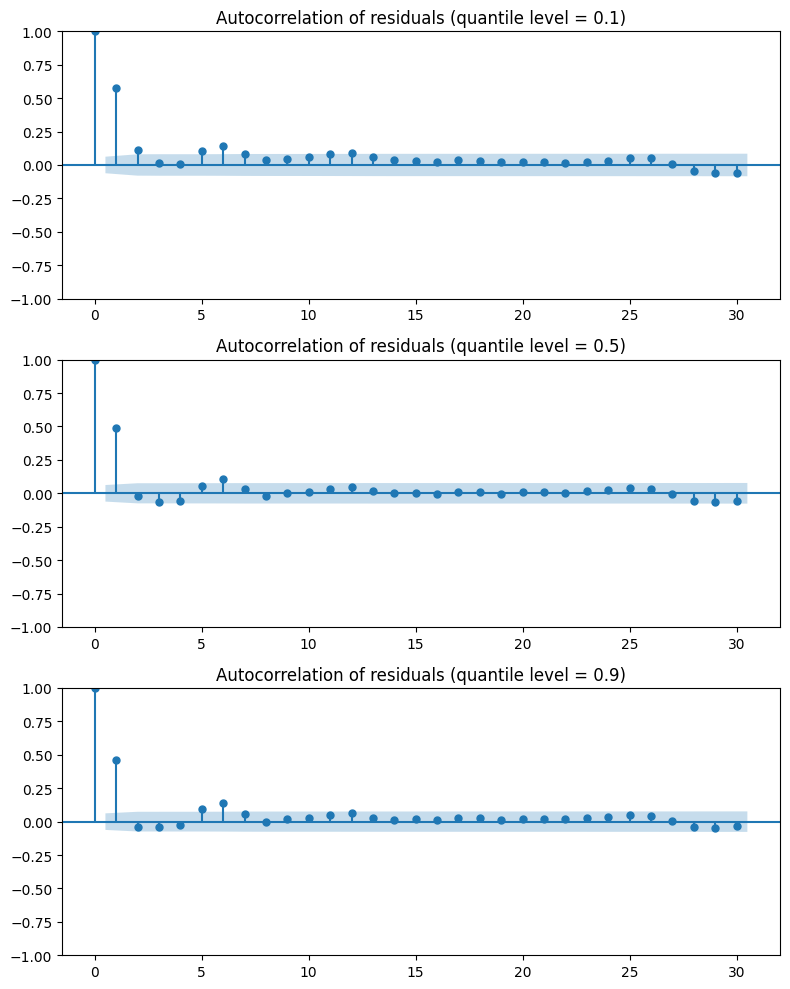

In [14]:
################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

#Autocorrelation fades away as the lags increase



In [15]:
################################ OLS estimation of the parameters ##############################
# Add lagged values of Y and epsilon
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon_y, 1)
epsilon_lag[0] = 0

# Construct the design matrix
X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))

#This line creates a new numpy array called X that is the design matrix for regression. 
# It is created by stacking columns of np.ones_like(x) (a vector of ones with the same shape as x), 
# y_lag, x, and epsilon_lag horizontally using np.column_stack(). 
# The first column of X is a vector of ones to represent the intercept term.

# Estimate the parameters
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Print the parameter estimates
print("alpha_hat = {:.4f}".format(beta_hat[0]))
print("beta_hat = {:.4f}".format(beta_hat[1]))
print("gamma_hat = {:.4f}".format(beta_hat[2]))
print("theta_hat = {:.4f}".format(beta_hat[3]))

alpha_hat = 2.0494
beta_hat = 0.6211
gamma_hat = 0.5330
theta_hat = 0.9801


In [16]:
################################ GLS estimation of the parameters ##############################
resid = y - X @ beta_hat# Compute the residuals

acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05) # Compute the ACF of the residuals

# Estimate the covariance parameters
sigma2 = np.var(resid) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)

# Compute the GLS estimator of the coefficients
beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y

# Print the parameter estimates
print("alpha_hat = {:.4f}".format(beta_gls[0]))
print("beta_hat = {:.4f}".format(beta_gls[1]))
print("gamma_hat = {:.4f}".format(beta_gls[2]))
print("theta_hat = {:.4f}".format(beta_gls[3]))

alpha_hat = 2.5511
beta_hat = 0.6069
gamma_hat = 0.5374
theta_hat = 1.1115


In [17]:
#GLS
alpha_hat = 2.4027
beta_hat = 0.6084
gamma_hat = 0.5409
theta_hat = 1.1107

#True values
alpha_y = 6
beta_y = 0.3
gamma = 0.9
theta = 0.9
sigma = 8

(array([0.60386457, 0.48085512, 0.49576536, 0.34666299, 0.29820473,
        0.27211181, 0.17892284, 0.18265039, 0.13791969, 0.11182677,
        0.10064409, 0.08573386, 0.05964095, 0.05218583, 0.04100315,
        0.04473071, 0.02609291, 0.04100315, 0.02982047, 0.01118268,
        0.02609291, 0.00745512, 0.0186378 , 0.00372756, 0.02236535,
        0.00372756, 0.02236535, 0.        , 0.00745512, 0.        ,
        0.        , 0.        , 0.        , 0.00372756, 0.        ,
        0.        , 0.00372756, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00372756, 0.        , 0.        , 0.00372756]),
 array([3.02442966e-03, 2.71296503e-01, 5.39568576e-01, 8.07840649e-01,
        1.07611272e+00, 1.34438480e+00, 1.61265687e+00, 1.88092894e+00,
        2.14920101e+00, 2.41747309e+00, 2.68574516e+00, 2.95401723e+00,
        3.22228931e+00, 3.49056138e+00, 3.75883345e+00, 4.02710553e+00,
        4.29537760e+00, 4.5636

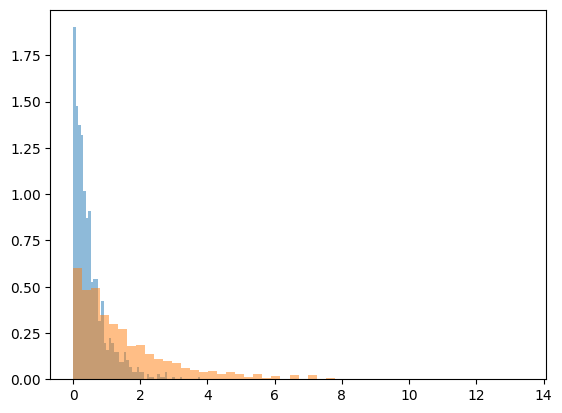

In [18]:
################################ Laplace normal ##############################
T=1000
z = np.random.exponential(0.5, T)
z2 = np.random.exponential(1.5, T)
plt.hist(z, bins=50, density=True, alpha=0.5)
plt.hist(z2, bins=50, density=True, alpha=0.5)


(array([0.01629331, 0.        , 0.        , 0.00814665, 0.00814665,
        0.04073326, 0.01629331, 0.        , 0.05702657, 0.04887992,
        0.02443996, 0.08961318, 0.09775983, 0.07331987, 0.12219979,
        0.1547864 , 0.1384931 , 0.22810628, 0.24439958, 0.34215942,
        0.3095728 , 0.37474603, 0.3095728 , 0.39918598, 0.46435921,
        0.4317726 , 0.48065251, 0.35845272, 0.37474603, 0.49694582,
        0.32586611, 0.25254623, 0.3095728 , 0.21181297, 0.21181297,
        0.21181297, 0.13034644, 0.19551967, 0.10590649, 0.08961318,
        0.1384931 , 0.05702657, 0.08961318, 0.01629331, 0.02443996,
        0.01629331, 0.00814665, 0.01629331, 0.00814665, 0.01629331]),
 array([-3.19991581, -3.07716601, -2.95441621, -2.83166641, -2.70891661,
        -2.58616681, -2.46341701, -2.34066721, -2.21791741, -2.09516761,
        -1.9724178 , -1.849668  , -1.7269182 , -1.6041684 , -1.4814186 ,
        -1.3586688 , -1.235919  , -1.1131692 , -0.9904194 , -0.8676696 ,
        -0.7449198 , -0.62

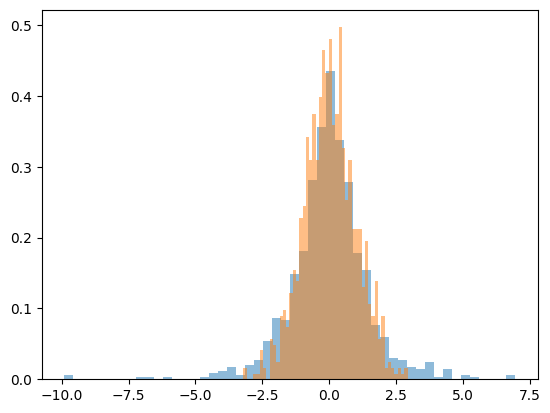

In [19]:
T=1000
z = np.random.laplace(0, 1, T)
z2 = np.random.laplace(0, 1, T)
z3 = np.random.normal(0, 1, T)
plt.hist(z, bins=50, density=True, alpha=0.5)
#plt.hist(z2, bins=50, density=True, alpha=0.5)
plt.hist(z3, bins=50, density=True, alpha=0.5)

In [22]:
################################ OLS estimation of the parameters ##############################
# Add lagged values of Y and epsilon
y_lag_2 = np.roll(y, 1)
y_lag_2[0] = 0

eps = np.random.laplace(0, 1, T)
eps_lag = np.roll(eps, 1)
eps_lag[0] = 0

# Construct the design matrix
X = np.column_stack((np.ones_like(x), y_lag, x, eps))

#This line creates a new numpy array called X that is the design matrix for regression. 
# It is created by stacking columns of np.ones_like(x) (a vector of ones with the same shape as x), 
# y_lag, x, and epsilon_lag horizontally using np.column_stack(). 
# The first column of X is a vector of ones to represent the intercept term.

# Estimate the parameters
beta_hat_2 = np.linalg.inv(X.T @ X) @ X.T @ y

# Print the parameter estimates
print("alpha_hat = {:.4f}".format(beta_hat_2[0]))
print("beta_hat = {:.4f}".format(beta_hat_2[1]))
print("gamma_hat = {:.4f}".format(beta_hat_2[2]))
print("theta_hat = {:.4f}".format(beta_hat_2[3]))


################################ GLS estimation of the parameters ##############################
resid_2 = y - X @ beta_hat_2# Compute the residuals

acf_resid_2, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05) # Compute the ACF of the residuals

# Estimate the covariance parameters
sigma2_2 = np.var(resid_2) * (1 - acf_resid_2[1])
sigma2_array_2 = np.full(T, sigma2_2)
rho_2 = acf_resid_2[1] / (1 - acf_resid_2[1])
S_2 = np.diag(sigma2_array_2) + rho_2 * np.diag(np.sqrt(sigma2_array_2[:-1] * sigma2_array_2[1:]), k=1) + rho_2 * np.diag(np.sqrt(sigma2_array_2[:-1] * sigma2_array_2[1:]), k=-1)

# Compute the GLS estimator of the coefficients
beta_gls_2 = np.linalg.inv(X.T @ np.linalg.inv(S_2) @ X) @ X.T @ np.linalg.inv(S_2) @ y

# Print the parameter estimates
print("alpha_hat_GLS2 = {:.4f}".format(beta_gls_2[0]))
print("beta_hat_GLS2 = {:.4f}".format(beta_gls_2[1]))
print("gamma_hat_GLS2 = {:.4f}".format(beta_gls_2[2]))
print("theta_hat_GLS2 = {:.4f}".format(beta_gls_2[3]))

alpha_hat = 1.8389
beta_hat = 0.6200
gamma_hat = 0.5366
theta_hat = -0.2093
alpha_hat_GLS2 = 1.2260
beta_hat_GLS2 = 0.6988
gamma_hat_GLS2 = 0.4345
theta_hat_GLS2 = -0.2613


In [23]:
#GLS
alpha_hat = 2.4027
beta_hat = 0.6084
gamma_hat = 0.5409
theta_hat = 1.1107

#True values
alpha_y = 6
beta_y = 0.3
gamma = 0.9
theta = 0.9
sigma = 8

#Laplace OLS
alpha_hat = 2.3253
beta_hat = 0.6166
gamma_hat = 0.5115
theta_hat = -0.2555
#Laplace GLS
alpha_hat_GLS2 = 1.6428
beta_hat_GLS2 = 0.7094
gamma_hat_GLS2 = 0.3930
theta_hat_GLS2 = -0.2704